# 一个隐藏层的神经网络实现复杂数据分类

这周将实现带有一个隐藏层的神经网络，你将看到此模型与使用逻辑回归性能的巨大差异。

**You will learn how to:** ：
- 用一个隐藏层实现二分类神经网络
- 使用一个非线性激活函数，如 tanh
- 计算交叉熵损失值
- 实现前向、反向传播


## 1 - 导入包 ##  

首先，导入该任务需要的全部功能包

- [numpy](www.numpy.org) 是 Python 中常用的科学计算库<br>
- [sklearn](http://scikit-learn.org/stable/) 提供简单而高效的数据挖掘和数据分析工具.<br>
- [matplotlib](http://matplotlib.org) 是 Python 中的绘图库.<br>
- testCases 提供了一些测试例子来评估函数
- planar_utils 提供各种在这个任务中使用的有用函数

In [1]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
from testCases import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets
from functools import reduce
import operator

%matplotlib inline

np.random.seed(1) # set a seed so that the results are consistent

## 2 - 数据集##  

首先，我们导入需要的数据。下面的代码将把 "flower" 二分类数据集导入到变量 `X` 和 `Y`.

In [2]:
X, Y = load_planar_dataset() 

使用 matplotlib 可视化数据集。数据看起来像一朵“花”，上面有一些红色(标签 y=0)点和蓝色(y=1)点。

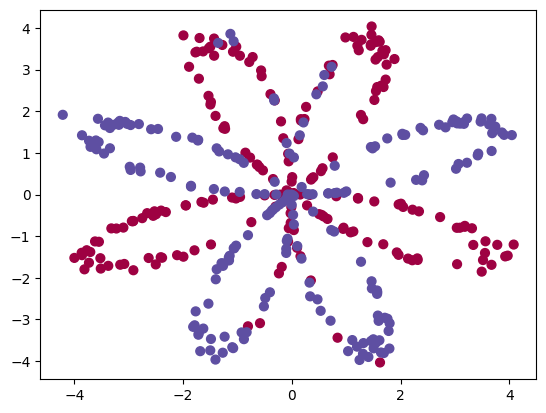

In [3]:
# Visualize the data:
plt.scatter(X[0, :], X[1, :], c=Y.reshape(-1,), s=40, cmap=plt.cm.Spectral);

你有：
    - 一个 numpy-array (矩阵) X ：包含你的特征(x1, x2)
    - 一个 numpy-array (向量) Y ：包含你的标签(red:0, blue:1)

**练习**:你有多少训练样本？变量`X` 和 `Y` 的 `shape` 是什么？<br>

**提示**: 获取 numpy 数组的维度 ? [(help)](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.shape.html)

In [4]:
### START CODE HERE ### (≈ 3 lines of code)
shape_X = X.shape
shape_Y = Y.shape
m = X.shape[1]  # training set size
### END CODE HERE ###

print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('I have m = %d training examples!' % (m))

The shape of X is: (2, 400)
The shape of Y is: (1, 400)
I have m = 400 training examples!


**Expected Output**:
       
<table style="width:20%">
  <tr>
    <td>**shape of X**</td>
    <td> (2, 400) </td> 
  </tr>
  <tr>
    <td>**shape of Y**</td>
    <td>(1, 400) </td> 
  </tr>
    <tr>
    <td>**m**</td>
    <td> 400 </td> 
  </tr>
</table>

## 3 - 简单的逻辑回归

在建立神经网络之前，我们先看看逻辑回归在这个问题上的表现。可以使用 sklearn 的内置函数来实现。运行下面的代码来训练逻辑回归分类器。

In [3]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X.T, Y.T.reshape(-1,));

绘制这些模型的决策边界。

Accuracy of logistic regression: 47 % (percentage of correctly labelled datapoints)


C:\Users\玉林\AppData\Local\Temp\ipykernel_26616\1104066596.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +


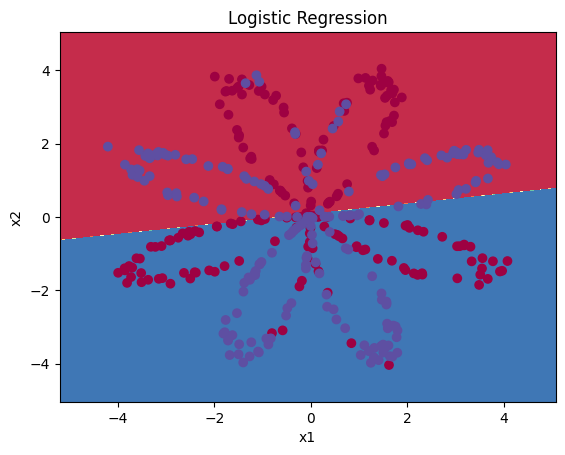

In [4]:
# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X, Y.reshape(-1,))
plt.title("Logistic Regression")

# Print accuracy
LR_predictions = clf.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

**Expected Output**:

<table style="width:20%">
  <tr>
    <td>**Accuracy**</td>
    <td> 47% </td> 
  </tr>
  
</table>


**解释**:数据集不是线性可分的,所以逻辑回归表现比较差。所以，我们来试试神经网络。<br>

## 4 - 神经网络模型

**我们的模型**:
<img src="images/classification_kiank.png" style="width:600px;height:300px;">

**数学原理**:

对于样本 $x^{(i)}$：
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1] (i)}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2] (i)}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

计算损失 $J$：
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

**提醒**: 建立神经网络的一般方法是：
    1. 定义神经网络结构（输入单元，隐藏单元等）
    2. 初始化模型的参数
    3. 循环：
        - 实现前向传播
        - 计算损失值
        - 反向传播获得梯度
        - 更新参数（梯度下降）

构建 `nn_model()` ，并学习正确的参数，就可以在新数据上做出预测。

### 4.1 - 定义神经网络结构 ####

**练习**: 定义三个变量
    - n_x: 输入层的大小
    - n_h: 隐藏层的大小（设置为4）
    - n_y: 输出层的大小

**提示**: 使用 X 和 Y 的维度来计算 n_x, n_y，隐藏层大小设置为4。

In [7]:
# GRADED FUNCTION: layer_sizes

def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    ### START CODE HERE ### (≈ 3 lines of code)
    n_x = X.shape[0]# size of input layer
    n_h = 4
    n_y = Y.shape[0]# size of output layer
    ### END CODE HERE ###
    return (n_x, n_h, n_y)

In [8]:
X_assess, Y_assess = layer_sizes_test_case()
(n_x, n_h, n_y) = layer_sizes(X_assess, Y_assess)
print("The size of the input layer is: n_x = " + str(n_x))
print("The size of the hidden layer is: n_h = " + str(n_h))
print("The size of the output layer is: n_y = " + str(n_y))

The size of the input layer is: n_x = 5
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 2


**Expected Output** (这不是将用于你网络的size大小，只是用于评估刚刚编写的函数是否正确).

<table style="width:20%">
  <tr>
    <td>**n_x**</td>
    <td> 5 </td> 
  </tr>
    <tr>
    <td>**n_h**</td>
    <td> 4 </td> 
  </tr>
    <tr>
    <td>**n_y**</td>
    <td> 2 </td> 
  </tr>
</table>

### 4.2 - 初始化模型的参数####

**练习**: 构建函数 `initialize_parameters()`。

**I说明**:
- 参考上面的神经网络图确认你的参数
- 随机值初始化权重矩阵 
    - 用：`np.random.randn(a,b) * 0.01` 初始化(a, b)维度的矩阵
- 把偏置向量初始化为零
    - 用：`np.zeros((a,b))`初始化(a, b) 维度的矩阵为零矩阵

In [8]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(2) # we set up a seed so that your output matches ours although the initialization is random.
    
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = np.random.randn(n_h,n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y,n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    ### END CODE HERE ###
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [10]:
n_x, n_h, n_y = initialize_parameters_test_case()

parameters = initialize_parameters(n_x, n_h, n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[0.]]


**Expected Output**:

<table style="width:90%">
  <tr>
    <td>**W1**</td>
    <td> [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]] </td> 
  </tr>
  
  <tr>
    <td>**b1**</td>
    <td> [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]] </td> 
  </tr>
  
  <tr>
    <td>**W2**</td>
    <td> [[-0.01057952 -0.00909008  0.00551454  0.02292208]]</td> 
  </tr>
  

  <tr>
    <td>**b2**</td>
    <td> [[ 0.]] </td> 
  </tr>
  
</table>



### 4.3 - 循环####

**问题**: 构建 `forward_propagation()`

**说明**: 
- 可以使用导入的函数 `sigmoid()`
- 可以使用numpy的函数 `np.tanh()` 
- 需实现的步骤：
    1. 用 `parameters[".."]` 检索字典 "parameters" 中的每个参数（"parameters" 是函数 `initialize_parameters()` 的返回值）
    2. 实现前向传播。计算：$Z^{[1]}, A^{[1]}, Z^{[2]}$ 和 $A^{[2]}$ （所有训练集样本预测的值）
- 反向传播所需的值存储在 `cache`里。 `cache` 将作为反向传播函数的输入。

In [11]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each parameter from the dictionary "parameters"
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    ### END CODE HERE ###
    
    # Implement Forward Propagation to calculate A2 (probabilities)
    ### START CODE HERE ### (≈ 4 lines of code)
    Z1 = np.dot(W1 , X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2 , A1) + b2
    A2 = sigmoid(Z2)
    ### END CODE HERE ###
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [12]:
X_assess, parameters = forward_propagation_test_case()

A2, cache = forward_propagation(X_assess, parameters)

# Note: we use the mean here just to make sure that your output matches ours. 
print(np.mean(cache['Z1']) ,np.mean(cache['A1']),np.mean(cache['Z2']),np.mean(cache['A2']))

-0.0004997557777419902 -0.000496963353231779 0.00043818745095914653 0.500109546852431


**Expected Output**:
<table style="width:55%">
  <tr>
    <td> -0.000499755777742 -0.000496963353232 0.000438187450959 0.500109546852 </td> 
  </tr>
</table>

现在你已经算出了 $A^{[2]}$ ，其中包含了每个样本的 $a^{[2](i)}$，可按如下方式计算损失函数：

$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{13}$$

**练习**: 构建 `compute_cost()` 计算损失 $J$ 的值。

实现交叉熵的方式很多，提供如下参考：

$- \sum\limits_{i=0}^{m}  y^{(i)}\log(a^{[2](i)})$:
```python
logprobs = np.multiply(np.log(A2),Y)
cost = - np.sum(logprobs)                # no need to use a for loop!
```

(你也可以调用 `np.multiply()` 然后调用 `np.sum()`，或直接使用 `np.dot()`).


In [13]:
# GRADED FUNCTION: compute_cost

def compute_cost(A2, Y, parameters):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2
    
    Returns:
    cost -- cross-entropy cost given equation (13)
    """
    
    m = Y.shape[1] # number of example

    # Compute the cross-entropy cost
    ### START CODE HERE ### (≈ 2 lines of code)
    logprobs = np.multiply(np.log(A2),Y) + np.multiply(np.log(1 - A2),1 - Y)
    cost = - np.sum(logprobs)/m
    ### END CODE HERE ###
    
    cost = np.squeeze(cost)     # makes sure cost is the dimension we expect. 
                                # E.g., turns [[17]] into 17 
    assert(isinstance(cost, float))
    
    return cost

In [14]:
A2, Y_assess, parameters = compute_cost_test_case()

print("cost = " + str(compute_cost(A2, Y_assess, parameters)))

cost = 0.6929198937761266


**Expected Output**:
<table style="width:20%">
  <tr>
    <td>**cost**</td>
    <td> 0.692919893776 </td> 
  </tr>
  
</table>

前向传播期间使用的 cache, 现在可以用于实现反向传播

**练习**: 构建函数 `backward_propagation()`

<img src="images/grad_summary.png" style="width:600px;height:300px;">

<!--
$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})$

$\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} $

$\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$

$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2}) $

$\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T $

$\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$

- Note that $*$ denotes elementwise multiplication.
- The notation you will use is common in deep learning coding:
    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$
    
!-->

- Tips :
    - 计算 dZ1 需要先计算 $g^{[1]'}(Z^{[1]})$。 因为 $g^{[1]}(.)$ 是一个 tanh 激励函数, 如果 $a = g^{[1]}(z)$ 则 $g^{[1]'}(z) = 1-a^2$. 所以你可以用 `(1 - np.power(A1, 2))` 计算 $g^{[1]'}(Z^{[1]})$。<br>

In [15]:
# GRADED FUNCTION: backward_propagation

def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    ### START CODE HERE ### (≈ 2 lines of code)
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    ### END CODE HERE ###
        
    # Retrieve also A1 and A2 from dictionary "cache".
    ### START CODE HERE ### (≈ 2 lines of code)
    A1 = cache["A1"]
    A2 = cache["A2"]
    ### END CODE HERE ###
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    ### START CODE HERE ### (≈ 6 lines of code, corresponding to 6 equations on slide above)
    dZ2 = A2 - Y
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), 1 - np.power(A1, 2))
    dW1 = (1 / m) * np.dot(dZ1, X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    ### END CODE HERE ###
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [16]:
parameters, cache, X_assess, Y_assess = backward_propagation_test_case()

grads = backward_propagation(parameters, cache, X_assess, Y_assess)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

dW1 = [[ 0.01018708 -0.00708701]
 [ 0.00873447 -0.0060768 ]
 [-0.00530847  0.00369379]
 [-0.02206365  0.01535126]]
db1 = [[-0.00069728]
 [-0.00060606]
 [ 0.000364  ]
 [ 0.00151207]]
dW2 = [[ 0.00363613  0.03153604  0.01162914 -0.01318316]]
db2 = [[0.06589489]]


**Expected output**:



<table style="width:80%">
  <tr>
    <td>**dW1**</td>
    <td> [[ 0.01018708 -0.00708701]
 [ 0.00873447 -0.0060768 ]
 [-0.00530847  0.00369379]
 [-0.02206365  0.01535126]] </td> 
  </tr>
  
  <tr>
    <td>**db1**</td>
    <td>  [[-0.00069728]
 [-0.00060606]
 [ 0.000364  ]
 [ 0.00151207]] </td> 
  </tr>
  
  <tr>
    <td>**dW2**</td>
    <td> [[ 0.00363613  0.03153604  0.01162914 -0.01318316]] </td> 
  </tr>
  

  <tr>
    <td>**db2**</td>
    <td> [[ 0.06589489]] </td> 
  </tr>
  
</table>  


**一般的梯度下降规则**: 其中 $\alpha$ 是学习率，$\theta$ 表示参数

**Illustration**: 梯度下降算法良好的学习速率（收敛）和差的学习速率（发散）展示。图片如下：

<img src="images/sgd.gif" style="width:400;height:400;"> <img src="images/sgd_bad.gif" style="width:400;height:400;">



In [17]:
# GRADED FUNCTION: update_parameters

def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieve each parameter from the dictionary "parameters"
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    ### END CODE HERE ###
    
    # Retrieve each gradient from the dictionary "grads"
    ### START CODE HERE ### (≈ 4 lines of code)
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    ## END CODE HERE ###
    
    # Update rule for each parameter
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    ### END CODE HERE ###
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [18]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]


**Expected Output**:


<table style="width:80%">
  <tr>
    <td>**W1**</td>
    <td> [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]</td> 
  </tr>
  
  <tr>
    <td>**b1**</td>
    <td> [[ -1.02420756e-06]
 [  1.27373948e-05]
 [  8.32996807e-07]
 [ -3.20136836e-06]]</td> 
  </tr>
  
  <tr>
    <td>**W2**</td>
    <td> [[-0.01041081 -0.04463285  0.01758031  0.04747113]] </td> 
  </tr>
  

  <tr>
    <td>**b2**</td>
    <td> [[ 0.00010457]] </td> 
  </tr>
  
</table>  

### 4.4 - 将 4.1, 4.2 和 4.3 部分整合在 nn_model() 中####

**练习**: 在 `nn_model()` 里构建神经网络模型


In [6]:
# GRADED FUNCTION: nn_model

def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # Initialize parameters, then retrieve W1, b1, W2, b2. Inputs: "n_x, n_h, n_y". Outputs = "W1, b1, W2, b2, parameters".
    ### START CODE HERE ### (≈ 5 lines of code)
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    ### END CODE HERE ###
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):
         
        ### START CODE HERE ### (≈ 4 lines of code)
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X, parameters)
        
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A2, Y, parameters)
 
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters, cache, X, Y)
 
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads)
        
        ### END CODE HERE ###
        
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

In [7]:
X_assess, Y_assess = nn_model_test_case()

parameters = nn_model(X_assess, Y_assess, 4, num_iterations=10000, print_cost=False)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

NameError: name 'layer_sizes' is not defined

**Expected Output**:

<table style="width:90%">
  <tr>
    <td>**W1**</td>
    <td> [[-4.18494056  5.33220609]
 [-7.52989382  1.24306181]
 [-4.1929459   5.32632331]
 [ 7.52983719 -1.24309422]]</td> 
  </tr>
  
  <tr>
    <td>**b1**</td>
    <td> [[ 2.32926819]
 [ 3.79458998]
 [ 2.33002577]
 [-3.79468846]]</td> 
  </tr>
  
  <tr>
    <td>**W2**</td>
    <td> [[-6033.83672146 -6008.12980822 -6033.10095287  6008.06637269]] </td> 
  </tr>
  

  <tr>
    <td>**b2**</td>
    <td> [[-52.66607724]] </td> 
  </tr>
  
</table>  

### 4.5 预测

**练习**: 构建 predict()来进行预测。

**Reminder **: predictions = $y_{prediction} = \mathbb 1 \text{{activation > 0.5}} = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$  
    
例如，如果要根据阈值将矩阵 X 元素设置为 0 和 1，则需要执行以下操作：```X_new = (X > threshold)```

In [8]:
# GRADED FUNCTION: predict

def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    ### START CODE HERE ### (≈ 2 lines of code)
    A2, cache = forward_propagation(X, parameters)
    predictions = np.round(A2)
    ### END CODE HERE ###
    
    return predictions

In [9]:
parameters, X_assess = predict_test_case()

predictions = predict(parameters, X_assess)
print("predictions mean = " + str(np.mean(predictions)))

NameError: name 'forward_propagation' is not defined

**Expected Output**: 


<table style="width:40%">
  <tr>
    <td>**predictions mean**</td>
    <td> 0.666666666667 </td> 
  </tr>
  
</table>

来看一下model的表现

Cost after iteration 0: 0.693048
Cost after iteration 1000: 0.288083
Cost after iteration 2000: 0.254385
Cost after iteration 3000: 0.233864
Cost after iteration 4000: 0.226792
Cost after iteration 5000: 0.222644
Cost after iteration 6000: 0.219731
Cost after iteration 7000: 0.217504
Cost after iteration 8000: 0.219504
Cost after iteration 9000: 0.218571


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

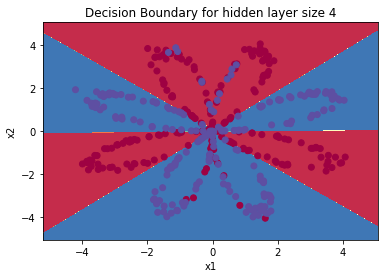

In [23]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y.reshape(-1,))
plt.title("Decision Boundary for hidden layer size " + str(4))

**Expected Output**:

<table style="width:40%">
  <tr>
    <td>**Cost after iteration 9000**</td>
    <td> 0.218607 </td> 
  </tr>
  
</table>


In [24]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 90%


**Expected Output**: 

<table style="width:15%">
  <tr>
    <td>**Accuracy**</td>
    <td> 90% </td> 
  </tr>
</table>

与逻辑回归相比，神经网络的准确性很高，能够学习高度非线性的决策边界。

现在，让我们尝试不同隐藏层大小对模型的影响。

### 4.6 - 调整隐藏层大小（optional）###

运行以下代码，你将观察到各种隐藏层大小的模型的不同性能。

Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.5 %
Accuracy for 5 hidden units: 91.25 %
Accuracy for 10 hidden units: 90.25 %
Accuracy for 20 hidden units: 90.0 %


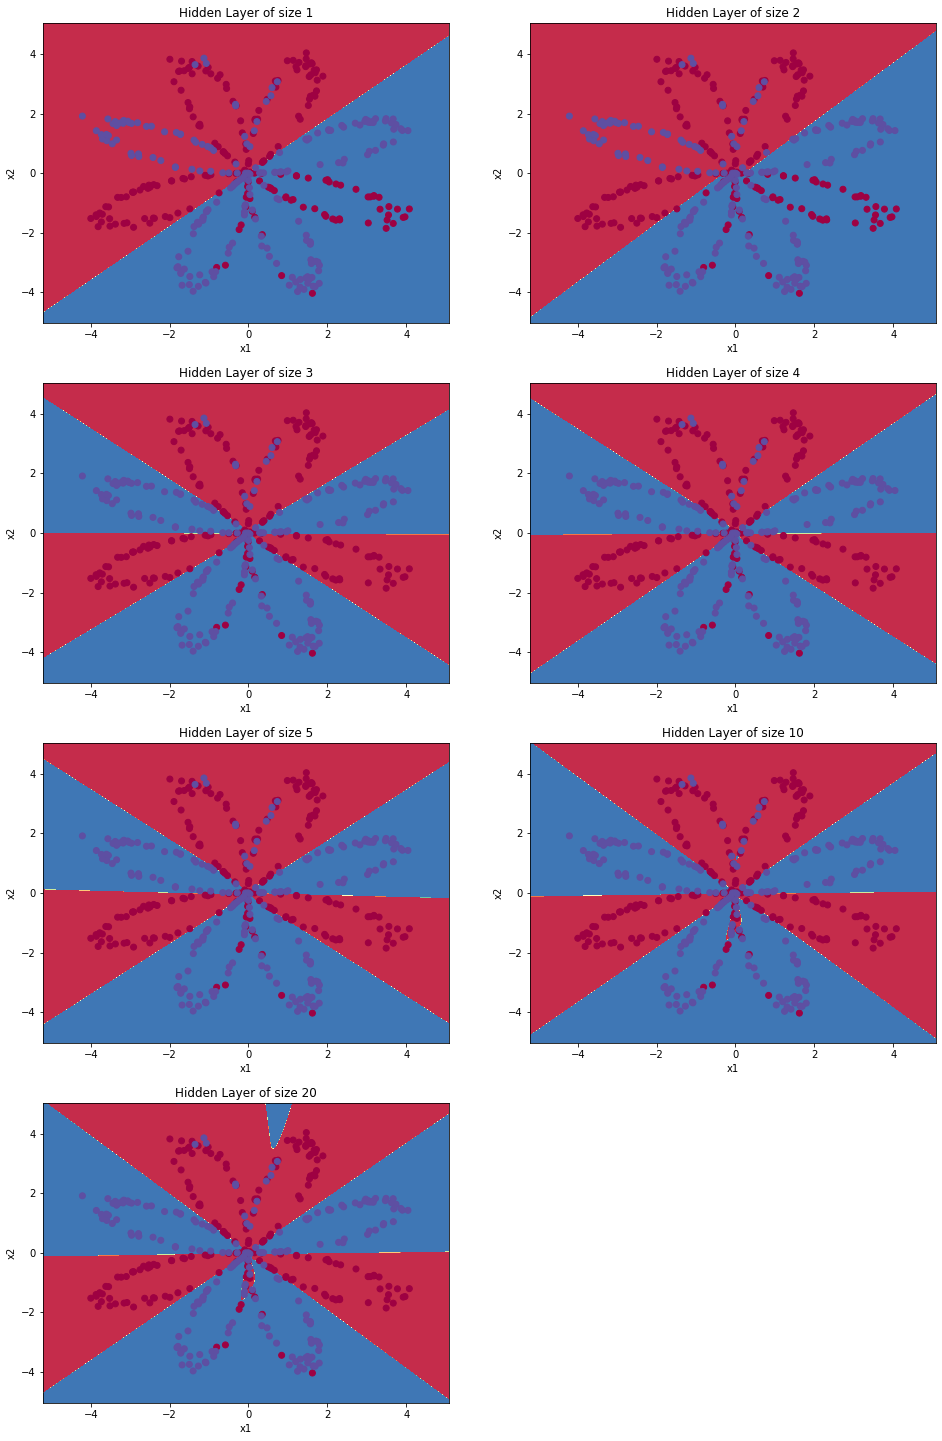

In [25]:
# This may take about 2 minutes to run

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 10, 20]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y.reshape(-1,))
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

**分析**:
- 较大的模型（有更多的隐藏单元）能够得到更好的效果，直到出现过拟合。
- 最好的隐藏层大小似乎在 n_h = 5 左右。很好拟合数据的同时，也不会引起明显过拟合。
- 可以加入正则化，它允许在使用非常大的模型（例如n_h = 50）时减少过拟合。


Reference:
- http://scs.ryerson.ca/~aharley/neural-networks/
- http://cs231n.github.io/neural-networks-case-study/